In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Imports**

In [2]:
!pip install einops
import os
import sys
import numpy as np
from tqdm import tqdm
from skimage import io
from PIL import Image
import torch
from skimage.morphology import label
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import numpy as np
import os
import torch.optim as optim
from torch.autograd import Variable
from skimage import io
from skimage.transform import resize

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00


# **UTILS**

In [3]:
"""
UNet
Common utility functions and classes
"""




# Base Configuration class
# Don't use this class directly. Instead, sub-class it and override

class Config():
    name = None

    img_width = 256
    img_height = 256

    img_channel = 3

    batch_size = 16

    learning_rate = 1e-3
    learning_momentum = 0.9
    weight_decay = 1e-4

    shuffle = False

    def __init__(self):
        self.IMAGE_SHAPE = np.array([
            self.img_width, self.img_height, self.img_channel
        ])

    def display(self):
        """Display Configuration values"""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))
        print("\n")


# Configurations

class Option(Config):
    """Configuration for training on Kaggle Data Science Bowl 2018
    Derived from the base Config class and overrides specific values
    """
    name = "DSB2018"
    img_height = 256
    img_width = 256
    # root dir of training and validation set
    root_dir = 'combined'

    # root dir of testing set
    test_dir = 'testing_data'

    # save segmenting results (prediction masks) to this folder
    results_dir = 'results'

    num_workers = 1  # number of threads for data loading
    shuffle = True  # shuffle the data set
    batch_size = 24  # GTX1060 3G Memory
    epochs = 100  #number of epochs to train
    is_train = True  # True for training, False for making prediction
    save_model = True  # True for saving the model, False for not saving the model

    n_gpu = 1  # number of GPUs

    learning_rate = 0.0001  # learning rate
    weight_decay = 1e-4  # weight decay

    pin_memory = True  # use pinned (page-locked) memory. when using CUDA, set to True

    is_cuda = torch.cuda.is_available()  # True --> GPU
    num_gpus = torch.cuda.device_count()  # number of GPUs
    checkpoint_dir = "./checkpoint"  # dir to save checkpoints
    dtype = torch.cuda.FloatTensor if is_cuda else torch.Tensor  # data type


"""
Dataset orgnization:
Read images and masks, combine separated mask into one
Write images and combined masks into specific folder
"""


class Utils(object):
    """
    Initialize image parameters from DSB2018Config class
    """

    def __init__(self, stage1_train_src, stage1_train_dest, stage1_test_src, stage1_test_dest):
        self.opt = Option
        self.stage1_train_src = stage1_train_src
        self.stage1_train_dest = stage1_train_dest
        self.stage1_test_src = stage1_test_src
        self.stage1_test_dest = stage1_test_dest

    # Combine all separated masks into one mask
    def assemble_masks(self, path):
        # mask = np.zeros((self.config.IMG_HEIGHT, self.config.IMG_WIDTH), dtype=np.uint8)
        mask = None
        for i, mask_file in enumerate(next(os.walk(os.path.join(path, 'masks')))[2]):
            mask_ = Image.open(os.path.join(path, 'masks', mask_file)).convert("RGB")
            # mask_ = mask_.resize((self.config.IMG_HEIGHT, self.config.IMG_WIDTH))
            mask_ = np.asarray(mask_)
            if i == 0:
                mask = mask_
                continue
            mask = mask | mask_
        # mask = np.expand_dims(mask, axis=-1)
        return mask

    # read all training data and save them to other folder
    def prepare_training_data(self):
        # get imageId
        train_ids = next(os.walk(self.stage1_train_src))[1]

        # read training data
        X_train = []
        Y_train = []
        print('reading training data starts...')
        sys.stdout.flush()
        for n, id_ in tqdm(enumerate(train_ids)):
            path = os.path.join(self.stage1_train_src, id_)
            dest = os.path.join(self.stage1_train_dest, id_)
            img = Image.open(os.path.join(path, 'images', id_ + '.png')).convert("RGB")
            mask = self.assemble_masks(path)
            os.mkdir(dest)
            img.save(os.path.join(dest, 'image.png'))
            Image.fromarray(mask).save(os.path.join(dest, 'mask.png'))

        print('reading training data done...')

    # read testing data and save them to other folder
    def prepare_testing_data(self):
        # get imageId
        test_ids = next(os.walk(self.stage1_test_src))[1]
        # read training data
        print('reading testing data starts...')
        sys.stdout.flush()
        for n, id_ in tqdm(enumerate(test_ids)):
            path = os.path.join(self.stage1_test_src, id_, 'images', id_ + '.png')
            dest = os.path.join(self.stage1_test_dest, id_)
            if not os.path.exists(dest):
                os.mkdir(dest)
            img = Image.open(path).convert("RGB")
            img.save(os.path.join(dest, 'image.png'))

        print('reading testing data done...')


def compute_iou(predictions, img_ids, val_loader):
    """
    compute IOU between two combined masks, this does not follow kaggle's evaluation
    :return: IOU, between 0 and 1
    """
    ious = []
    for i in range(0, len(img_ids)):
        pred = predictions[i]
        img_id = img_ids[i]
        mask_path = os.path.join(Option.root_dir, img_id, 'mask.png')
        mask = np.asarray(Image.open(mask_path).convert('L'), dtype=np.bool_)
        union = np.sum(np.logical_or(mask, pred))
        intersection = np.sum(np.logical_and(mask, pred))
        iou = intersection / union
        ious.append(iou)
    df = pd.DataFrame({'img_id': img_ids, 'iou': ious})
    df.to_csv('IOU.csv', index=False)


# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)


def encode_and_save(preds_test_upsampled, test_ids):
    """
    Use run-length-encoding encode the prediction masks and save to csv file for submitting
    :param preds_test_upsampled: list, for each elements, numpy array (Width, Height)
    :param test_ids: list, for each elements, image id
    :return:
        save to csv file
    """
    # save as imgs
    for i in range(0, len(test_ids)):
        path = os.path.join(Option.results_dir, test_ids[i])
        if not os.path.exists(path):
            os.mkdir(path)
        # Image.fromarray(preds_test_upsampled[i]).save(os.path.join(path,'prediction.png'))
        plt.imsave(os.path.join(path, 'prediction.png'), preds_test_upsampled[i], cmap='gray')
    # save as encoding
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))

    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv('sub-dsbowl2018.csv', index=False)




# **DATA**

In [4]:

# IMAGE_HEIGHT = 256
# IMAGE_WIDTH = 256

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

opt = Option()

transform0 = A.Compose([
    A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    # ToTensorV2()
])

transform = A.Compose([
    A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT),
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.Rotate(p=0.25),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

class Dataset_Class(Dataset):
    def __init__(self, root_dir, transform=transform0):
        self.root_dir = root_dir
        self.transform = transform
        self.folder_list = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.folder_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.root_dir + '/' + self.folder_list[index] + '/' + "image.png")).convert("RGB")
        mask1 = Image.open(os.path.join(self.root_dir + '/' + self.folder_list[index] + '/' + "mask.png")).convert('L')
        image = np.array(img, dtype=np.float32)
        mask = np.array(mask1, dtype=np.float32)
        mask = np.expand_dims(mask, axis=-1)
        # mask1 = np.asarray(mask1)
        # k = np.expand_dims(mask1, axis=-1)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
        image = image.type(opt.dtype)
        mask = mask.type(opt.dtype)
        image = torch.reshape(image, (3, IMAGE_WIDTH, IMAGE_HEIGHT))
        mask = torch.reshape(mask, (1, IMAGE_WIDTH, IMAGE_HEIGHT))
        mask = mask/255.0
        return image, mask
    
    
def get_train_loader(root_training_dir='/kaggle/input/unet-project-dataset-isic-2017/Total Dataset/training_data'):
    data = Dataset_Class(root_dir=root_training_dir)
    
    BATCH_SIZE = opt.batch_size
    dataloader_train = DataLoader(
        data, batch_size=BATCH_SIZE, shuffle=True)

    print("TRAIN DATALOADER DONE")
    return dataloader_train


def get_val_loader(root_val_dir='/kaggle/input/unet-project-dataset-isic-2017/Total Dataset/validation_data'):
    
    data = Dataset_Class(root_dir=root_val_dir)
    
    BATCH_SIZE = opt.batch_size
    dataloader_train = DataLoader(
        data, batch_size=BATCH_SIZE, shuffle=True)

    print("VAL DATALOADER DONE")
    return dataloader_train


# def get_test_loader(root_test_dir='testing_data'):
    
#     data = Dataset_Class(root_dir=root_test_dir)
#     BATCH_SIZE = opt.batch_size
#     dataloader_train = DataLoader(
#         data, batch_size=BATCH_SIZE, shuffle=True)

# **MODELS**

In [5]:
# Utility Functions
''' when filter kernel= 3x3, padding=1 makes in&out matrix same size'''

class MHCA(nn.Module):
    def __init__(self, n_feats, ratio):
        """
        MHCA spatial-channel attention module.
        :param n_feats: The number of filter of the input.
        :param ratio: Channel reduction ratio.
        """
        super(MHCA, self).__init__()

        out_channels = int(n_feats // ratio)

        head_1 = [
            nn.Conv2d(in_channels=n_feats, out_channels=out_channels, kernel_size=1, padding=0, bias=True),
            nn.ReLU(True),
            nn.Conv2d(in_channels=out_channels, out_channels=n_feats, kernel_size=1, padding=0, bias=True)
        ]

        kernel_size_sam = 3
        head_2 = [
            nn.Conv2d(in_channels=n_feats, out_channels=out_channels, kernel_size=kernel_size_sam, padding=0, bias=True),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=n_feats, kernel_size=kernel_size_sam, padding=0, bias=True)
        ]

        kernel_size_sam_2 = 5
        head_3 = [
            nn.Conv2d(in_channels=n_feats, out_channels=out_channels, kernel_size=kernel_size_sam_2, padding=0, bias=True),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=n_feats, kernel_size=kernel_size_sam_2, padding=0, bias=True)
        ]

        self.head_1 = nn.Sequential(*head_1)
        self.head_2 = nn.Sequential(*head_2)
        self.head_3 = nn.Sequential(*head_3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        res_h1 = self.head_1(x)
        res_h2 = self.head_2(x)
        res_h3 = self.head_3(x)
        m_c = self.sigmoid(res_h1 + res_h2 + res_h3)
        res = x * m_c
        return res
    
def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )


def down_pooling():
    return nn.MaxPool2d(2)


def up_pooling(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
# UNet class

class UNet(nn.Module):
    def __init__(
            self, input_channels=3, nclasses=1, features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        in_channels = input_channels
        out_channels = nclasses
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

class UNet2(nn.Module):
    def __init__(self, input_channels, nclasses):
        super().__init__()
        # go down
        self.conv1 = conv_bn_relu(input_channels, 16)
        self.conv2 = conv_bn_relu(16, 32)
        self.conv3 = conv_bn_relu(32, 64)
        self.conv4 = conv_bn_relu(64, 128)
        self.conv5 = conv_bn_relu(128, 256)
        self.down_pooling = nn.MaxPool2d(2)

        # go up
        self.up_pool6 = up_pooling(256, 128)
        self.conv6 = conv_bn_relu(256, 128)
        self.up_pool7 = up_pooling(128, 64)
        self.conv7 = conv_bn_relu(128, 64)
        self.up_pool8 = up_pooling(64, 32)
        self.conv8 = conv_bn_relu(64, 32)
        self.up_pool9 = up_pooling(32, 16)
        self.conv9 = conv_bn_relu(32, 16)

        self.conv10 = nn.Conv2d(16, nclasses, 1)

        # test weight init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # normalize input data
        x = x / 255.
        # go down
        x1 = self.conv1(x)
        print("X1 shape: ", x1.size())
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        print("X2 Shape: ", x2.size())
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        print("X3 Shape: ", x3.size())
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        print("X4 Shape: ", x4.size())
        p4 = self.down_pooling(x4)
        x5 = self.conv5(p4)
        print("X5 Shape: ", x5.size())

        # go up
        p6 = self.up_pool6(x5)
        x6 = torch.cat([p6, x4], dim=1)
        x6 = self.conv6(x6)

        p7 = self.up_pool7(x6)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)

        output = self.conv10(x9) 
        output = F.sigmoid(output)

        return output


"""
Code for Attention UNET
"""


class conv_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up_conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        return x * psi


class AttU_Net(nn.Module):
    def __init__(self, input_channels=3, nclasses=1):
        super(AttU_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(ch_in=input_channels, ch_out=64)
        self.Conv2 = conv_block(ch_in=64, ch_out=128)
        self.Conv3 = conv_block(ch_in=128, ch_out=256)
        self.Conv4 = conv_block(ch_in=256, ch_out=512)
        self.Conv5 = conv_block(ch_in=512, ch_out=1024)

        self.Up5 = up_conv(ch_in=1024, ch_out=512)
        self.Att5 = Attention_block(F_g=512, F_l=512, F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512, ch_out=256)
        self.Att4 = Attention_block(F_g=256, F_l=256, F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

        self.Up3 = up_conv(ch_in=256, ch_out=128)
        self.Att3 = Attention_block(F_g=128, F_l=128, F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

        self.Up2 = up_conv(ch_in=128, ch_out=64)
        self.Att2 = Attention_block(F_g=64, F_l=64, F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64, nclasses, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5, x=x4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=x3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=x1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


"""
Code for R2_UNET
"""


class Recurrent_block(nn.Module):
    def __init__(self, ch_out, t=2):
        super(Recurrent_block, self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        for i in range(self.t):

            if i == 0:
                x1 = self.conv(x)

            x1 = self.conv(x + x1)
        return x1


class RRCNN_block(nn.Module):
    def __init__(self, ch_in, ch_out, t=2):
        super(RRCNN_block, self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out, t=t),
            Recurrent_block(ch_out, t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x + x1


class R2U_Net(nn.Module):
    def __init__(self, input_channels=3, nclasses=1, t=2):
        super(R2U_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=input_channels, ch_out=64, t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64, ch_out=128, t=t)

        self.RRCNN3 = RRCNN_block(ch_in=128, ch_out=256, t=t)

        self.RRCNN4 = RRCNN_block(ch_in=256, ch_out=512, t=t)

        self.RRCNN5 = RRCNN_block(ch_in=512, ch_out=1024, t=t)

        self.Up5 = up_conv(ch_in=1024, ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512, t=t)

        self.Up4 = up_conv(ch_in=512, ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256, t=t)

        self.Up3 = up_conv(ch_in=256, ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128, t=t)

        self.Up2 = up_conv(ch_in=128, ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64, t=t)

        self.Conv_1x1 = nn.Conv2d(64, nclasses, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

# Trans-UNet

In [6]:
"""
Modules
"""
import torch
from torch import nn, einsum
import torch.nn.functional as F



class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class CrossAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_k = nn.Linear(dim, inner_dim , bias=False)
        self.to_v = nn.Linear(dim, inner_dim , bias = False)
        self.to_q = nn.Linear(dim, inner_dim, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x_qkv):
        b, n, _, h = *x_qkv.shape, self.heads

        k = self.to_k(x_qkv)
        k = rearrange(k, 'b n (h d) -> b h n d', h = h)

        v = self.to_v(x_qkv)
        v = rearrange(v, 'b n (h d) -> b h n d', h = h)

        q = self.to_q(x_qkv[:, 0].unsqueeze(1))
        q = rearrange(q, 'b n (h d) -> b h n d', h = h)



        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out
        
        
        
"""
Vision Transformer
"""


class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, head_num):
        super().__init__()

        self.head_num = head_num
        self.dk = (embedding_dim // head_num) ** (1 / 2)

        self.qkv_layer = nn.Linear(embedding_dim, embedding_dim * 3, bias=False)
        self.out_attention = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x, mask=None):
        qkv = self.qkv_layer(x)

        query, key, value = tuple(rearrange(qkv, 'b t (d k h ) -> k b h t d ', k=3, h=self.head_num))
        energy = torch.einsum("... i d , ... j d -> ... i j", query, key) * self.dk

        if mask is not None:
            energy = energy.masked_fill(mask, -np.inf)

        attention = torch.softmax(energy, dim=-1)

        x = torch.einsum("... i j , ... j d -> ... i d", attention, value)

        x = rearrange(x, "b h t d -> b t (h d)")
        x = self.out_attention(x)

        return x


class MLP(nn.Module):
    def __init__(self, embedding_dim, mlp_dim):
        super().__init__()

        self.mlp_layers = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_dim, embedding_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        x = self.mlp_layers(x)

        return x


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim):
        super().__init__()

        self.multi_head_attention = MultiHeadAttention(embedding_dim, head_num)
        self.mlp = MLP(embedding_dim, mlp_dim)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        _x = self.multi_head_attention(x)
        _x = self.dropout(_x)
        x = x + _x
        x = self.layer_norm1(x)

        _x = self.mlp(x)
        x = x + _x
        x = self.layer_norm2(x)

        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim, block_num=12):
        super().__init__()

        self.layer_blocks = nn.ModuleList(
            [TransformerEncoderBlock(embedding_dim, head_num, mlp_dim) for _ in range(block_num)])

    def forward(self, x):
        for layer_block in self.layer_blocks:
            x = layer_block(x)

        return x


class ViT(nn.Module):
    def __init__(self, img_dim, in_channels, embedding_dim, head_num, mlp_dim,
                 block_num, patch_dim, classification=True, num_classes=1):
        super().__init__()

        self.patch_dim = patch_dim
        self.classification = classification
        self.num_tokens = (img_dim // patch_dim) ** 2
        print(f'Num of tokens: {self.num_tokens}')
        self.token_dim = in_channels * (patch_dim ** 2)
        print(f'Token dimension: {self.token_dim}')

        self.projection = nn.Linear(self.token_dim, embedding_dim)
        self.embedding = nn.Parameter(torch.rand(self.num_tokens + 1, embedding_dim))
        print(f'Embedding shape: {self.embedding.shape}')
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        self.dropout = nn.Dropout(0.1)

        self.transformer = TransformerEncoder(embedding_dim, head_num, mlp_dim, block_num)

        if self.classification:
            self.mlp_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        img_patches = rearrange(x,
                                'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.patch_dim, patch_y=self.patch_dim)

        batch_size, tokens, _ = img_patches.shape

        project = self.projection(img_patches)
        token = repeat(self.cls_token, 'b ... -> (b batch_size) ...',
                       batch_size=batch_size)

        patches = torch.cat([token, project], dim=1)
        patches += self.embedding[:tokens + 1, :]

        x = self.dropout(patches)
        x = self.transformer(x)
        x = self.mlp_head(x[:, 0, :]) if self.classification else x[:, 1:, :]

        return x
    

"""
Trans-UNet
"""
class EncoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, base_width=64):
        super().__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        width = int(out_channels * (base_width / 64))

        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=1, stride=1, bias=False)
        self.norm1 = nn.BatchNorm2d(width)

        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=2, groups=1, padding=1, dilation=1, bias=False)
        self.norm2 = nn.BatchNorm2d(width)

        self.conv3 = nn.Conv2d(width, out_channels, kernel_size=1, stride=1, bias=False)
        self.norm3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_down = self.downsample(x)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = x + x_down
        x = self.relu(x)

        return x


class DecoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=True)
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, x_concat=None):
        x = self.upsample(x)

        if x_concat is not None:
            x = torch.cat([x_concat, x], dim=1)

        x = self.layer(x)
        return x


class Encoder(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.encoder1 = EncoderBottleneck(out_channels, out_channels * 2, stride=2)
        self.encoder2 = EncoderBottleneck(out_channels * 2, out_channels * 4, stride=2)
        self.encoder3 = EncoderBottleneck(out_channels * 4, out_channels * 8, stride=2)

        self.vit_img_dim = img_dim // patch_dim
        print(f'vit_img_dim = img_dim//patch_dim\n={img_dim}/{patch_dim} = {self.vit_img_dim}')
        self.vit = ViT(self.vit_img_dim, out_channels * 8, out_channels * 8,
                       head_num, mlp_dim, block_num, patch_dim=1, classification=False)

        self.conv2 = nn.Conv2d(out_channels * 8, 512, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(512)

    def forward(self, x):
#         print(f'Shape of x: {x.shape}')
        x = self.conv1(x)
#         print(f'Shape of x after conv1: {x.shape}')
        x = self.norm1(x)
#         print(f'Shape after norm1: {x.shape}')
        x1 = self.relu(x)

        x2 = self.encoder1(x1)
#         print(f'Shape of x after encoder1: {x.shape}')
        x3 = self.encoder2(x2)
#         print(f'Shape of x after encoder2: {x.shape}')
        x = self.encoder3(x3)
#         print(f'Shape of x after encoder3: {x.shape}')
        x = self.vit(x)
#         print(f'Shape of x after vit: {x.shape}')
        x = rearrange(x, "b (x y) c -> b c x y", x=self.vit_img_dim, y=self.vit_img_dim)
#         print(f'Shape of x after vit rearrangement: {x.shape}')
        x = self.conv2(x)
#         print(f'Shape of x after conv2 on vit-rearranged output: {x.shape}')
        x = self.norm2(x)
#         print(f'Shape of x after norm2: {x.shape}')
        x = self.relu(x)

        return x, x1, x2, x3


class Decoder(nn.Module):
    def __init__(self, out_channels, class_num):
        super().__init__()

        self.decoder1 = DecoderBottleneck(out_channels * 8, out_channels * 2)
        self.decoder2 = DecoderBottleneck(out_channels * 4, out_channels)
        self.decoder3 = DecoderBottleneck(out_channels * 2, int(out_channels * 1 / 2))
        self.decoder4 = DecoderBottleneck(int(out_channels * 1 / 2), int(out_channels * 1 / 8))

        self.conv1 = nn.Conv2d(int(out_channels * 1 / 8), class_num, kernel_size=1)

    def forward(self, x, x1, x2, x3):
#         print('Entered Decoder')
        x = self.decoder1(x, x3)
        x = self.decoder2(x, x2)
        x = self.decoder3(x, x1)
        x = self.decoder4(x)
        x = self.conv1(x)

        return x


class TransUNet(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim, class_num):
        super().__init__()

        self.encoder = Encoder(img_dim, in_channels, out_channels,
                               head_num, mlp_dim, block_num, patch_dim)

        self.decoder = Decoder(out_channels, class_num)

    def forward(self, x):
        x, x1, x2, x3 = self.encoder(x)
        x = self.decoder(x, x1, x2, x3)

        return x


# Metrics Definition

In [7]:
def get_accuracy(SR, GT, threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)
    corr = torch.sum(SR == GT)
    tensor_size = SR.size(0) * SR.size(1) * SR.size(2) * SR.size(3)
    acc = float(corr) / float(tensor_size)

    return acc


def get_sensitivity(SR, GT, threshold=0.5):
    # Sensitivity == Recall
    SR = SR > threshold
    GT = GT > threshold

    # TP : True Positive
    # FN : False Negative
    TP = torch.logical_and(SR, GT)
    FN = torch.logical_and((SR == 0), (GT == 1))

    SE = float(torch.sum(TP)) / (float(torch.sum(TP + FN)) + 1e-6)

    return SE


def get_specificity(SR, GT, threshold=0.5):
    SR = SR > threshold
    GT = GT > threshold

    # TN : True Negative
    # FP : False Positive
    TN = torch.logical_and((SR == 0), (GT == 0))
    FP = torch.logical_and((SR == 1), (GT == 0))

    SP = float(torch.sum(TN)) / (float(torch.sum(TN + FP)) + 1e-6)

    return SP


def get_precision(SR, GT, threshold=0.5):
    SR = SR > threshold
    GT = GT > threshold

    # TP : True Positive
    # FP : False Positive
    TP = torch.logical_and(SR, GT)
    P = SR

    PC = float(torch.sum(TP)) / (float(torch.sum(P)) + 1e-6)

    return PC


def get_F1(SR, GT, threshold=0.5):
    # Sensitivity == Recall
    SE = get_sensitivity(SR, GT, threshold=threshold)
    PC = get_precision(SR, GT, threshold=threshold)

    F1 = 2 * SE * PC / (SE + PC + 1e-6)

    return F1


def get_JS(SR, GT, threshold=0.5):
    # JS : Jaccard similarity
    SR = SR > threshold
    GT = GT > threshold
    Inter = torch.sum(torch.logical_and(SR, GT))
    Union = torch.sum(torch.logical_or(SR, GT))

    JS = float(Inter) / (float(Union) + 1e-6)

    return JS


def get_DC(SR, GT, threshold=0.5):
    # DC : Dice Coefficient
    SR = SR > threshold
    GT = GT > threshold
    Inter = torch.sum(torch.logical_and(SR, GT)).item()
    Union = torch.sum(torch.logical_or(SR, GT)).item()
    DC = float(2 * Inter) / (float(Inter + Union) + 1e-6)

    return DC

# **TRAIN**

In [8]:
def get_val_metrics(mod, loader):
    mod.eval()
    n_total_steps = len(train_loader)
    los_vall = 0
    accuracy_vall = 0
    sensitivity_vall = 0
    specificity_vall = 0
    precision_vall = 0
    f1_vall = 0
    js_vall = 0
    dc_vall = 0
    print('Entering the loop')
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data.type(opt.dtype)), Variable(target.type(opt.dtype))
        output = model(data)
        loss = criterion(output, target)
        los_vall += loss.item()
        accuracy_vall += get_accuracy(output, target)
        sensitivity_vall += get_sensitivity(output, target)
        specificity_vall += get_specificity(output, target)
        precision_vall += get_precision(output, target)
        f1_vall += get_F1(output, target)
        js_vall += get_JS(output, target)
        dc_vall += get_DC(output, target)
    los_vall = los_vall / n_total_steps
    accuracy_vall = accuracy_vall / n_total_steps
    sensitivity_vall = sensitivity_vall / n_total_steps
    specificity_vall = specificity_vall / n_total_steps
    precision_vall = precision_vall / n_total_steps
    f1_vall = f1_vall / n_total_steps
    js_vall = js_vall / n_total_steps
    dc_vall = dc_vall / n_total_steps
    return los_vall, accuracy_vall, sensitivity_vall, specificity_vall, precision_vall, f1_vall, js_vall, dc_vall
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
opt = Option()
# model = R2U_Net(input_channels=3, nclasses=1)
model = TransUNet(img_dim=128,
                  in_channels=3,
                  out_channels=128,
                  head_num=4,
                  mlp_dim=512,
                  block_num=8,
                  patch_dim=16,
                  class_num=1)
model.to(device)
# train_loader = get_val_loader()
optimizer = optim.Adam(model.parameters(), lr=opt.learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 50, 0.00001)
criterion = nn.BCEWithLogitsLoss().cuda()
train_loader = get_train_loader()
val_loader = get_val_loader()

los = 0
num_batches = 0
accuracy_train = 0
sensitivity_train = 0
specificity_train = 0
precision_train = 0
f1_train = 0
js_train = 0
dc_train = 0

los_val = 0
accuracy_train_val = 0
sensitivity_train_val = 0
specificity_train_val = 0
precision_train_val = 0
f1_train_val = 0
js_train_val = 0
dc_train_val = 0

avg_loss = []
avg_accuracy_train = []
avg_sensitivity_train = []
avg_specificity_train = []
avg_precision_train = []
avg_f1_train = []
avg_js_train = []
avg_dc_train = []
epoch_store = []

avg_loss_val = []
avg_accuracy_val = []
avg_sensitivity_val = []
avg_specificity_val = []
avg_precision_val = []
avg_f1_val = []
avg_js_val = []
avg_dc_val = []

n_total_steps = len(train_loader)
print('Entering the loop')
for epoch in range(0, opt.epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        # data = sample_batched['image']
        # target = sample_batched['mask']
        data, target = Variable(data.type(opt.dtype)), Variable(target.type(opt.dtype))
        # print(f'Data max is: {data.max()}')
        # print(f'Target max is: {target.max()}')
        optimizer.zero_grad()
        output = model(data)
#         output = torch.sigmoid(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        print(f'Epoch [{epoch + 1}/{opt.epochs}], Step [{batch_idx + 1}/{n_total_steps}], Loss: {loss.item():.4f}')
        los += loss.item()
        accuracy_train += get_accuracy(output, target)
        sensitivity_train += get_sensitivity(output, target)
        specificity_train += get_specificity(output, target)
        precision_train += get_precision(output, target)
        f1_train += get_F1(output, target)
        js_train += get_JS(output, target)
        dc_train += get_DC(output, target)
#         break
    scheduler.step()
    avg_loss.append(los / n_total_steps)
    avg_accuracy_train.append(accuracy_train / n_total_steps)
    avg_precision_train.append(precision_train / n_total_steps)
    avg_sensitivity_train.append(sensitivity_train / n_total_steps)
    avg_specificity_train.append(specificity_train / n_total_steps)
    avg_f1_train.append(f1_train / n_total_steps)
    avg_js_train.append(js_train / n_total_steps)
    avg_dc_train.append(dc_train / n_total_steps)
    epoch_store.append(epoch + 1)
    los = 0
    accuracy_train = 0
    sensitivity_train = 0
    specificity_train = 0
    precision_train = 0
    f1_train = 0
    js_train = 0
    dc_train = 0
   
    # For validation set:
    
    
#     break
datas = {'Average Training Accuracy': avg_accuracy_train,
         'Average Training Loss': avg_loss,
         'Average Training Precision': avg_precision_train,
         'Average Training Sensitivity': avg_precision_train,
         'Average Training Specificity': avg_specificity_train,
         'Average Training F1': avg_f1_train,
         'Average Training JS': avg_js_train,
         'Average Training Dice Coefficient': avg_dc_train,
         'Epochs': epoch_store
         }

df = pd.DataFrame(datas)
df.to_csv("Attn_UNET_MODEL_METRICS_train.csv")
if opt.save_model:
    torch.save(model.state_dict(), 'Attn_UNET_Model_2.pt')

print('TRAIN 1 program run complete')
print(f'Train datas: {datas}')

# For validation DATA
# los_val,accuracy_train_val ,sensitivity_train_val ,specificity_train_val ,precision_train_val ,f1_train_val ,js_train_val ,dc_train_val  = get_val_metrics(loader=val_loader,mod=model)
# avg_loss_val.append(los_val)
# avg_accuracy_val.append(accuracy_train_val)
# avg_sensitivity_val.append(sensitivity_train_val)
# avg_specificity_val.append(specificity_train_val)
# avg_precision_val.append(precision_train_val)
# avg_f1_val.append(f1_train_val)
# avg_js_val.append(js_train_val)
# avg_dc_val.append(dc_train_val)
# #For VALIDATION DATA
# datas_val = {'Average Val Accuracy': avg_accuracy_train,
#          'Average Val Loss': avg_loss,
#          'Average Val Precision': avg_precision_train,
#          'Average Val Sensitivity': avg_precision_train,
#          'Average Val Specificity': avg_specificity_train,
#          'Average Val F1': avg_f1_train,
#          'Average Val JS': avg_js_train,
#          'Average Val Dice Coefficient': avg_dc_train,
#          }

# df = pd.DataFrame(datas_val)
# df.to_csv("Attn_UNET_MODEL_METRICS_VAL.csv")
# print('VAL saving complete')
# print(f'VAL data:{datas_val}')

vit_img_dim = img_dim//patch_dim
=128/16 = 8
Num of tokens: 64
Token dimension: 1024
Embedding shape: torch.Size([65, 1024])
TRAIN DATALOADER DONE
VAL DATALOADER DONE
Entering the loop
Epoch [1/100], Step [1/84], Loss: 0.8346
Epoch [1/100], Step [2/84], Loss: 0.7918
Epoch [1/100], Step [3/84], Loss: 0.7659
Epoch [1/100], Step [4/84], Loss: 0.7740
Epoch [1/100], Step [5/84], Loss: 0.7153
Epoch [1/100], Step [6/84], Loss: 0.7386
Epoch [1/100], Step [7/84], Loss: 0.7112
Epoch [1/100], Step [8/84], Loss: 0.6837
Epoch [1/100], Step [9/84], Loss: 0.6935
Epoch [1/100], Step [10/84], Loss: 0.6648
Epoch [1/100], Step [11/84], Loss: 0.6703
Epoch [1/100], Step [12/84], Loss: 0.6406
Epoch [1/100], Step [13/84], Loss: 0.6644
Epoch [1/100], Step [14/84], Loss: 0.6135
Epoch [1/100], Step [15/84], Loss: 0.6225
Epoch [1/100], Step [16/84], Loss: 0.6193
Epoch [1/100], Step [17/84], Loss: 0.6135
Epoch [1/100], Step [18/84], Loss: 0.6018
Epoch [1/100], Step [19/84], Loss: 0.6073
Epoch [1/100], Step [20/84

torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


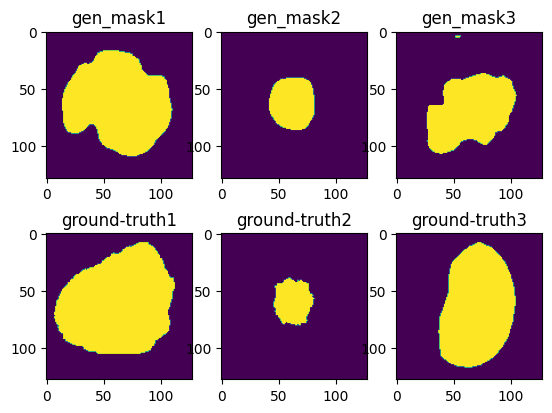

In [9]:


image_list = ['/kaggle/input/unet-project-dataset-isic-2017/Total Dataset/training_data/ISIC_0000000/image.png',
    '/kaggle/input/unet-project-dataset-isic-2017/Total Dataset/training_data/ISIC_0000001/image.png',
    '/kaggle/input/unet-project-dataset-isic-2017/Total Dataset/training_data/ISIC_0000004/image.png']

masks_list = ['/kaggle/input/unet-project-dataset-isic-2017/Total Dataset/training_data/ISIC_0000000/mask.png',
    '/kaggle/input/unet-project-dataset-isic-2017/Total Dataset/training_data/ISIC_0000001/mask.png',
    '/kaggle/input/unet-project-dataset-isic-2017/Total Dataset/training_data/ISIC_0000004/mask.png'
]

transform0 = A.Compose([
    # A.Resize(width=256, height=256),
    A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    # ToTensorV2()
])

def img_mask_preprocessing(img_list=[],mask_list=[],ismask=False):
    final_data_list = []
    if ismask:
        for index in range(len(img_list)):
            img = Image.open(img_list[index])
            mask1 = Image.open(mask_list[index]).convert('L')
            img = np.array(img, dtype=np.uint8)
            mask1 = np.asarray(mask1)
            k = np.expand_dims(mask1, axis=-1)
            mask = np.array(k, dtype=np.float32)
            transformed = transform0(image=img, mask=mask)
            p = transformed['image']
            q = transformed['mask']
            p = torch.from_numpy(p)
            q = torch.from_numpy(q)
            p = p.type(opt.dtype)
            q = q.type(opt.dtype)
            p = torch.reshape(p, (3, IMAGE_WIDTH, IMAGE_HEIGHT))
            q = torch.reshape(q, (1, IMAGE_WIDTH, IMAGE_HEIGHT))
            q = q/255.0    
            final_data_list.append((p,q))  
    else:
        for index in range(len(img_list)):
            img = Image.open(img_list[index])
            img = np.array(img, dtype=np.float32)
            transformed = transform0(image=img)
            p = transformed['image']
            p = torch.from_numpy(p)
            p = p.type(opt.dtype)
            p = torch.reshape(p, (3, IMAGE_WIDTH, IMAGE_HEIGHT)) 
            final_data_list.append(p)
    
#     unprocessed_image = []
#     for i in range(len(img_list)):
#         img = Image.open(img_list[index])
#         img = np.array(img, dtype=np.uint8)
#         unprocessed_image.append(img)
    return final_data_list

def plotting(ismask_=True,model=model):
    data = img_mask_preprocessing(img_list=image_list,mask_list=masks_list,ismask=ismask_)
    if ismask_:
        fig,axes = plt.subplots(2,3)
    else:
        fig, axes = plt.subplots(1,3)
    
#     for idx, item in enumerate(images):
#         item = item.cpu(
#         axes[0, idx].imshow(item)
#         axes[0, idx].set_title(('image'+str(idx+1)))
        
    for idx, k in enumerate(data):
        if ismask_:
            item,_ = k
        else:
            item = k
        item = torch.unsqueeze(item,0)
        # item = torch.unsqueeze(torch.squeeze(item),0).detach().cpu()
        output = model(item)
        output = output>0.3
        print(output.size())
        output = torch.unsqueeze(torch.squeeze(output),0).detach().cpu()
        if ismask_:
            axes[0, idx].imshow(output.permute(1,2,0))
            axes[0, idx].set_title(('gen_mask'+str(idx+1)))
        else:
            axes[0,idx].imshow(output.permute(1,2,0))
            axes[0,idx].set_title(('gen_mask'+str(idx+1)))
    
    if ismask_:
        for idx, k in enumerate(data):
            if ismask_:
                _,item = k
            item = item.detach().cpu()
            axes[1, idx].imshow(item.permute(1,2,0))
            axes[1, idx].set_title(('ground-truth'+str(idx+1)))
    plt.show()
    # plt.savefig('saved_plots/generated_masks.png')

plotting()